In [1]:
#from numba import jit

import numpy as np
import scipy.linalg as sl
import scipy.integrate as si
import scipy.optimize
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import time

In [2]:
# our Fourier representation will use basis functions from n = -nmax to n = nmax
nmax = 128

# size of spatial domain
a = 16

In [3]:
# Let's first check our RK4 method against a time-independent potential
# After validating the method, we will move on to time-dependent potentials

# symmetric double well potential
#def v(x):
#    return 0.25*(x**2 - 25)**2

# dimensionless quantum harmonic oscillator potential
def v(x):
    return 0.5*x**2

In [4]:
# compute the V matrix

# create a vector of sampled values from the potential
# then use FFT (or quadrature) to transform the sampled potential
# to the Fourier basis

# sample
# the integer '100' can be adjusted to improve resolution
# if we set f_sample = 2*nmax, then we are sampling at the Nyquist frequency
f_sample = 100 * 2 * nmax
t, dt = np.linspace(-a, a, f_sample+2, endpoint=False, retstep=True)

# FFT
# in one line take the FFT of the sampled potential,
# divide by the number of time steps, and take only nmax coefficients
# and their conjugate, i.e., truncate our Fourier basis.
y = (np.fft.rfft(v(t)) / t.size)[:(2*nmax+1)]

In [5]:
# construct the Hamiltonian matrix

# this stores the Fourier series coefficients for n-m=0 to n-m=2*nmax
vrow = y * (-1)**np.arange(2*nmax+1)

# create Toeplitz matrix
vmat = sl.toeplitz(r=vrow,c=np.conj(vrow))

# kinetic matrix
kmat = np.diag( np.arange(-nmax,nmax+1)**2 * np.pi**2 / (2*a**2) )

# Hamiltonian matrix 
hmat = kmat + vmat

# check whether Hamiltonian is Hermitian
print(np.linalg.norm( hmat - np.conj(hmat.T) ))

# eigendecomposition
spec, states = np.linalg.eigh(hmat)

# check whether this diagonalizes hmat
# note that if this is close to zero it means that
# hmat = states @ np.diag(spec) @ np.conj(states).T
np.linalg.norm( hmat @ states - states @ np.diag(spec) )

# check whether we have a unitary matrix
print(np.linalg.norm( states @ np.conj(states).T - np.eye(2*nmax+1) ))

0.0
3.9638375739374176e-14


In [6]:
# find indices that sort eigenvalues
# np.argsort returns the indices that would sort an array.
# ordering = np.argsort(spec)

# spatial grid for the purposes of plotting
xvec = np.linspace(-a, a, 1025)

# convert basis coefficients into wavefunction on grid by matrix multiplication
nvec = np.arange(-nmax,nmax+1)
convmat = np.exp(1j*np.pi*np.outer(nvec, xvec)/a)/np.sqrt(2*a)

In [14]:
def rk4_prop(an, dt):
    # set the time step size
    k1 = -1j*hmat@an
    k2 = -1j*hmat@(an + 0.5*dt*k1)
    k3 = -1j*hmat@(an + 0.5*dt*k2)
    k4 = -1j*hmat@(an + dt*k3)
    return an + (1/6)*dt*(k1 + 2*k2 + 2*k3 + k4)

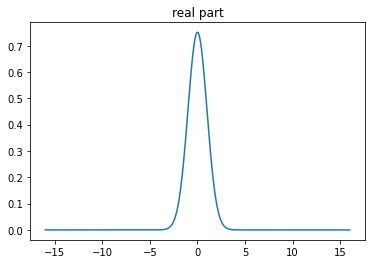

1.0


In [7]:
# verify RK4 method against analytical solution
# of the quantum harmonic oscillator (QHO)

from scipy import special

# define normalized QHO wave function
def qhowave(n, t, x=xvec):
    # take discrete samples from wave function
    hermfn = special.hermite(n)
    qhonorm = 1 / np.sqrt(2**n*special.factorial(n)*np.sqrt(np.pi))
    timeindqhovec = qhonorm*np.exp(-(x**2)/2)*hermfn(x)
    # make vector of t-t_0
    phase = np.exp(-1j*(n+0.5)*t)
    return timeindqhovec*phase

qhotruth = qhowave(0, 0)
# quick visual check of the probability density at t_0
plt.plot(xvec, np.real(qhotruth))
plt.title('real part')
plt.show()

print(np.sum(np.abs(qhotruth)**2 * (xvec[1]-xvec[0])))

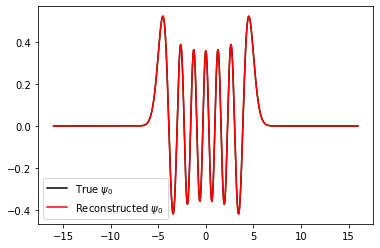

8.182968419473815e-14


In [9]:
# This code defines the initial QHO state for the system
# and then converts the state to the "a" basis

# which state to start in
n = 12

# transform initialize wave function to a basis
vraw = np.zeros(nmax+1, dtype=np.complex128)
for thisn in range(nmax+1):
    def integ(x):
        return (2*a)**(-0.5)*np.exp(-1j*np.pi*thisn*x/a)*qhowave(n,0,x)
    def rinteg(x):
        return np.real(integ(x))
    def iinteg(x):
        return np.imag(integ(x))
    vraw[thisn] = si.quad(rinteg, a=-a, b=a)[0] + 1j*si.quad(iinteg, a=-a, b=a)[0]

# initial state of system in "a" basis
ainit = np.concatenate([np.conjugate(np.flipud(vraw[1:])), vraw])

# check whether psi0 is represented OK
plt.plot(xvec, np.real( qhowave(n,0) ), color='black', label=r"True $\psi_0$")
psi0recon = np.real(ainit @ convmat)
plt.plot(xvec, psi0recon, color='red', label=r"Reconstructed $\psi_0$")
plt.legend()
plt.show()

# compute the L2 norm of the difference between the analytical
# and reconstructed wave functions
print(np.linalg.norm(psi0recon - qhowave(n,0)))

In [15]:
# This code performs the propagation of the system given
# the initial state defined above

# define right hand side of system's equations
# in the Fourier basis. To use in scipy.integrate RK4 method 
#def H(t, an):
#    return -1j*hmat@an

# set final time
T = np.sqrt(2)

# compute exact solution at final time
psitrue = qhowave(n, T)

# initialize variables 
obj = []
dtvec = []

for i in range(6,11):
    # set the number of steps, an integer
    nsteps = 10*(2**i)
    
    # calculate & store the time step required to reach final time T using nsteps
    dt = T / nsteps
    dtvec.append(dt)
    
    # check to make sure it's all kosher
    print([dt, nsteps, dt*nsteps, T])
 

    # propagate the "a" vector of coefficients for nsteps using
    # own RK4 function
    amat = np.copy(ainit)
    for j in range(nsteps):
        amat = rk4_prop(amat, dt)
    
    # propagate the "a" vector of coefficients for nsteps using
    # scipy RK4 method
    #amat = si.RK45(H, t0=0, y0=ainit, t_bound=T)
    #amat = amat.y
    
    # compute the wave function in space from each "a" vector
    psirk4 = amat @ convmat

    # store the norm of the error
    obj.append( np.linalg.norm(psitrue - psirk4) )

[0.002209708691207961, 640, 1.414213562373095, 1.4142135623730951]
[0.0011048543456039805, 1280, 1.414213562373095, 1.4142135623730951]
[0.0005524271728019902, 2560, 1.414213562373095, 1.4142135623730951]
[0.0002762135864009951, 5120, 1.414213562373095, 1.4142135623730951]
[0.00013810679320049756, 10240, 1.414213562373095, 1.4142135623730951]


[0.002209708691207961, 0.0011048543456039805, 0.0005524271728019902, 0.0002762135864009951, 0.00013810679320049756]
[4.850602437687537e-07, 3.031650739110975e-08, 1.8948553090042803e-09, 1.1850027655537817e-10, 7.473562398307828e-12]


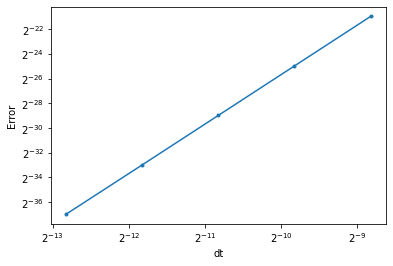

Estimated Slope: 3.996502080455186


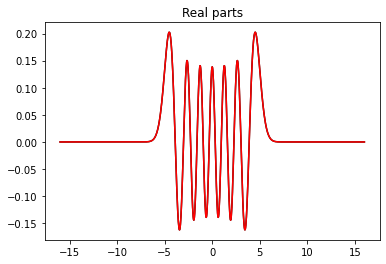

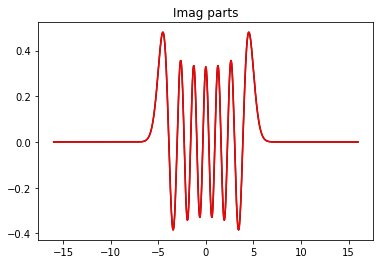

In [16]:
# log base 2
logdt = np.log(dtvec)/np.log(2)
logobj = np.log(obj)/np.log(2)

print(dtvec)
print(obj)

plt.loglog(dtvec, obj, '.-', base=2)
plt.xlabel('dt')
plt.ylabel('Error')
plt.show()

print( "Estimated Slope: ", end="" )
print( (logobj[0] - logobj[-1])/(logdt[0] - logdt[-1]) )

plt.plot(xvec, np.real(psitrue),color='black')
plt.plot(xvec, np.real(psirk4),color='red')
plt.title('Real parts')
plt.show()
plt.plot(xvec, np.imag(psitrue),color='black')
plt.plot(xvec, np.imag(psirk4),color='red')
plt.title('Imag parts')
plt.show()

**Introduction**

In HARISH’S ADJOINT NOTE, HE discretizes the 1D non-dimensionalized time-dependent Schrodinger equation (TDSE)

$$
i \partial_t \psi = \mathcal{H} \psi
$$

(for a single partial?) using the Fourier basis in complex exponential form, i.e.,

$$
\phi_n(x) = (2 a)^{-1/2} e^{i \pi n x/a}.
$$

HE first establishes the “mathematical rules” of the system/basis (given below), which provide the tools necessary for deriving the Time-Dependent Schrödinger Ordinary Differential Equation (TDSODE)

$$
\frac{d}{dt} \vec{a}(t) = -i H \vec{a}(t)
$$

where $\vec{a}(t)$ is the vector of all coefficients $\{a_n(t)\}_{n=-N}^N$, and $H$ is the matrix representation of the Hamiltonian operator $\mathcal{H}$. In this notebook, we will emply the forth order Runga-Kutta method (RK4)to solve the TDSODE.

To calculate the Hamiltonian matrix $H$, we begin with

$$
H_{mn} = (\phi_m, \mathcal{H} \phi_n)
$$

then plug in the definition of the Hamiltonian operator, i.e., $\mathcal{H} = \mathcal{K} + \mathcal{V}$. The result of this is

$$
H = K + V
$$

where $K$ is the potential energy matrix which is diagonal in the Fourier basis

$$
K_{mn} = (\phi_m, \mathcal{K} \phi_m) = \frac{ \pi^2 n^2 }{ 2 a^2 } \delta_{mn}
$$

and $V$ is the potential energy matrix

$$
V_{mn}(t) = \frac{1}{2a} \int_{x=-a}^a e^{i \pi (n-m) x/a} v(x, t) \, dx
$$

Note, $V_{mn}$ is constant for all $(m,n)$ where that $n-m$ is constant. This means that the matrix $V$ is Toeplitz, i.e., constant along diagonals. Additionally, $V_{mn}$ at some specitic time $t$ is equivalent to the *Fourier series coefficient* of the function $v(x, t)$ at that time. If we let $t_n = n \Delta t$ can compute $V_{mn}(t_n)$ by FFT.

The wave function $\psi(x, t)$ can be represented in the orthonormal basis (given above) as:

$$
\psi(x,t) = \sum_{n=-N}^N a_n(t) \phi_n(x)
$$

which has the norm

$$
\| \psi(x,t) \| = (\psi, \psi)^{1/2} = \left( \sum_{n=-N}^N |a_n(t)|^2 \right)^{1/2}
$$

**Mathematical rules of our system**

Let $\{ \phi_n(x) \}_{n=-\infty}^\infty$ be a collection of basis functions.  We take these functions to be elements of the Hilbert space $L^2([-a,a]; \mathbb{C})$.  This Hilbert space consists of complex-valued, square-integrable functions with domain $[-a,a]$.  The inner product in this space is

$\displaystyle (f, g) = \int_{x=-a}^a \overline{f(x)} g(x) \, dx$,

and therefore the norm is

$\displaystyle \| f \| = (f, f)^{1/2} = \left( \int_{x=-a}^a |f(x)|^2 \, dx \right)^{1/2}$.

We assume the basis is $orthonormal$ and $complete$ in $L^2([-a,a]; \mathbb{C})$.  Orthonormality means that

$\displaystyle (\phi_m, \phi_n) = \delta_{mn} = \begin{cases} 1 & m = n \\ 0 & m \neq n. \end{cases}$

Completeness means that for any function $f \in L^2([-a,a]; \mathbb{C})$, there exists an infinite sequence of coefficients $\{ \alpha_n \}_{n=-\infty}^\infty$ such that when we form the expansion

$\displaystyle g_N(x) = \sum_{n=-N}^N \alpha_n \phi_n(x)$,

the expansion $converges$ to $f$ as $N \to \infty$, i.e., $\lim_{N \to \infty} \| f - g_N \| = 0$.  Or, to put it another way, we can represent any $f$ (in our Hilbert space) arbitrarily well by expanding $f$ as a linear combination of basis functions.

Using this complete, orthonormal basis, we can represent the kinetic and potential operators as matrices:

$\displaystyle K_{mn} = (\phi_m, \mathcal{K} \phi_n) = \int_{x=-a}^a \overline{\phi_m(x)} (\mathcal{K} \phi_n)(x) \, dx = -\frac{1}{2} \int_{x=-a}^a \overline{\phi_m(x)} \partial_{xx} \phi_n(x) \, dx$

$\displaystyle V_{mn} = (\phi_m, \mathcal{V} \phi_n) = \int_{x=-a}^a \overline{\phi_m(x)} (\mathcal{V} \phi_n)(x) \, dx = \int_{x=-a}^a \overline{\phi_m(x)} v(x) \phi_n(x) \, dx$


The Fourier basis is both complete and orthonomal, that is, $\displaystyle (\phi_m, \phi_n) = \frac{1}{2a} \int_{x=-a}^a e^{i \pi (n-m) x/a} \, dx = \frac{1}{2a} \frac{a}{i \pi (n-m)} \left( e^{i \pi (n-m)} - e^{-i \pi (n-m)} \right) = 0$, when $n = m$, $(\phi_n, \phi_n) = 1$.

**Periodicity**

We write our potential function as $\displaystyle v(x, t) = \sum_{j=-2N}^{j=2N} \theta_j (t) \phi_j(x)$. By virtue of the Fourier basis we have chosen, this potential function will be periodic with period $2a$ on the interval $[-a,a]$.  This is because, for all $j$ and $t$, we have $\displaystyle \phi_n(x + 2a) = (2 a)^{-1/2} e^{i \pi n (x+2a)/a} =  (2 a)^{-1/2} e^{i \pi n x/a} e^{2 \pi i n} = \phi_n(x)$. The same is true for $\psi(x,t)$; it will also be $2a$-periodic on $[-a,a]$.

**Boundary conditions**

We assume the wave function decays (as a function of spatial coordinate x) to (approximatly) zero near the boundaries $x= \pm a$. Thus if we choose $a$ sufficiently large, and if our initial wave function is localized in space near $x=0$, the behavior of the potential beyond the boundaries $x = \pm a$ is of no practical concern to us. Therefore, as we generate data using our forward method, we must monitor our wave function and check that during the time interval of interest, its magnitude stays close to zero near the boundaries.  If this isn't true, we need to rerun the simulation with larger $a$.

**Derivation of TDSODE**

We begin by expanding the wave function $\psi(x,t)$ in the orthonormal basis given above:
$$
\psi(x,t) = \sum_{n=-N}^N a_n(t) \phi_n(x).
$$
As a result of our basis being orthonormal, the inner product of the wave function $\psi$ with some basis function $\phi_m$ is:
$$
(\phi_m, \psi) = a_m(t)
$$

If we multiply the expanded wave function by $i$ and take a time-derivative on both sides, we obtain
$$
(\phi_m, i \partial_t \psi) = i \frac{d}{dt} a_m(t).
$$
Now we substitute the TDSE and our representation of the wave function into the left-hand side and obtain
$$
\sum_{n=-N}^N (\phi_m, \mathcal{H} \phi_n) a_n(t) = i \frac{d}{dt} a_m(t)
$$
Rearranging, we see that
$$
\frac{d}{dt} \vec{a}(t) = -i H \vec{a}(t)
$$
where $\vec{a}(t)$ is the vector of all coefficients $\{a_n(t)\}_{n=-N}^N$, and $H$ is the matrix representation of the Hamiltonian operator $\mathcal{H}$. The latter statement is equivalent to saying that $H_{mn} = (\phi_m, \mathcal{H} \phi_n)$.

What has been derived is an ordinary differential equation (ODE) for the coefficients $\vec{a}(t)$, or to put it another way, this ODE represents the TDSE in our orthonormal basis. Solving this ODE will give the dynamics of the coefficient vector $\vec{a}(t)$.  If we know the coefficient vector $\vec{a}(t)$ at some $t > 0$, then using the expansion for the wave function above, we can compute $\psi(x,t)$ at each $x \in [-a,a]$.

**Norm of wave function in Fourier basis**

The wave function $\psi(x, t)$ can be represented in the orthonormal basis (given above) as:

$$
\psi(x,t) = \sum_{n=-N}^N a_n(t) \phi_n(x)
$$

The norm of some function $f$ in this system is 

$$
\| f \| = (f, f)^{1/2} = \left( \int_{x=-a}^a |f(x)|^2 \, dx \right)^{1/2}
$$

So the norm of the wave function $\psi(x, t)$ is
$$
\begin{align}
\| \psi(x,t) \|
&= (\psi, \psi)^{1/2} \\
&= \left( \int_{x=-a}^a \overline{\psi(x,t)} \psi(x,t) \, dx \right)^{1/2} \\
&= \left( \int_{x=-a}^a \overline{\sum_{m=-N}^N a_m(t) \phi_m(x)} \sum_{n=-N}^N a_n(t) \phi_n(x) \, dx \right)^{1/2} \\
&= \left( \sum_{m=-N}^N \sum_{n=-N}^N \int_{x=-a}^a \overline{a_m(t)} a_n(t) \overline{\phi_m(x)} \phi_n(x) \, dx \right)^{1/2} \\
&= \left( \sum_{m=-N}^N \sum_{n=-N}^N \overline{a_m(t)} a_n(t) \int_{x=-a}^a \overline{\phi_m(x)} \phi_n(x) \, dx \right)^{1/2} \\
&= \left( \sum_{m=-N}^N \sum_{n=-N}^N \overline{a_m(t)} a_n(t)\, \left(\phi_m(x), \phi_n(x)\right)\right)^{1/2} \\
&= \left( \sum_{m=-N}^N \sum_{n=-N}^N \overline{a_m(t)} a_n(t)\, \delta_{mn} \right)^{1/2} \\
&= \left( \sum_{n=-N}^N \overline{a_n(t)} a_n(t) \right)^{1/2} \\
&= \left( \sum_{n=-N}^N |a_n(t)|^2 \right)^{1/2}
\end{align}
$$

**RK4 method**
The RK4 method solves initial value problems of the form:

$$
\frac{dy}{dt} = f(t,y),\quad y(t_0)=y_0
$$

where $y$ is the time-dependent vector we are approximating.

Given a step-size $h>0$ the RK4 method is defined as

$$
y_{n+1} = y_n + \frac{1}{6} h \left(k_1 + 2 k_2 + 2 k_3 + k_4\right)
$$

$$
t_{n+1} = t_n + h
$$

where

$$
k_1 = f\left(t_n, y_n\right)
$$

$$
k_2 = f\left(t_n + \frac{1}{2} h,\ y_n + \frac{1}{2} h k_1\right)
$$

$$
k_3 = f\left(t_n + \frac{1}{2} h,\ y_n + \frac{1}{2} h k_2\right)
$$

$$
k_4 = f\left(t_n + h,\ y_n + h k_3\right)
$$

**Dynamics - RK4 solution for the TDSODE**

In the forward problem, $V$ and $\psi(x,0)$ are specified and the task is to solve for $\psi(x,t)$ for $t > 0$. We will do this numerically through a basis function method.  Our spatial domain is the closed interval $[-a,a]$.

The dynamics of the TDSE in an orthonormal basis is defined by the TDSODE (derived below)

$$
\frac{d}{dt} \vec{a}(t) = -i H(t) \vec{a}(t),\quad \vec{a}(0) = \vec{a}_0
$$

which can be solved by the RK4 method like

$$
\vec{a}_{n+1} = \vec{a}_n + \frac{1}{6} h \left(k_1 + 2 k_2 + 2 k_3 + k_4\right)
$$

$$
t_{n+1} = t_n + h
$$

where

$$
k_1 = -i H\left(t_n\right) \vec{a}_n
$$

$$
k_2 = -i H\left(t_n + \frac{1}{2} h\right)\left(\vec{a}_n + \frac{1}{2} h k_1\right)
$$

$$
k_3 = -i H\left(t_n + \frac{1}{2} h\right) \left(\vec{a}_n + \frac{1}{2} h k_2\right)
$$

$$
k_4 = -i H\left(t_n+h\right) \left(\vec{a}_n + h k_3\right)
$$

Given an initial condition $\psi(x,0)$, we compute the initial coefficient vector via

$$
a_m(0) = (\phi_m, \psi(\cdot, 0)) = (2a)^{-1/2} \int_{x=-a}^a e^{-i \pi m x/a} \psi(x,0) \, dx
$$

this can done via the FFT again (however, this doesn't lead to accurate reconstructions) or by quadrature (which we use below).

**Quantum Harmonic Oscillator**

The normalized dimensionless wave function for the quantum harmonic oscillator is
$$
\psi\left( \tilde{x} \right) = \frac{1}{\sqrt{2^n n! \sqrt{\pi}}} e^{-\tilde{x}^2 / 2} \mathcal{H}_n\left( \tilde{x} \right)
$$
where $\mathcal{H}_n$ is the $n$-th Harmite function and $\tilde{x}$ is the dimensionless coordinate variable.

**Verifying RK4 Method**

Compute
$$
\| \psi_{\mathrm{true}}(t) - \psi_{\mathrm{RK4}}(t) \|
$$
for dt=0.1, dt=0.05, dt=0.025, and so on, where the norm is over $t \in [0, T]$ and also over $x \in [-L, L]$. If the method is correct, this should converge to zero (especially if the system has been initialized in a pure QHO state).